In [1]:
import torch
import pandas as pd, numpy as np, matplotlib, matplotlib.pyplot as plt
import datetime
from torch import nn
from torch.nn import init
from torch.autograd import Variable

In [2]:
df = pd.read_csv('mental_health_survey.csv')

In [3]:

one_hot = ['Gender', 'Country', 'state', 'self_employed', 
           'family_history', 'work_interfere', 'no_employees',
           'remote_work', 'tech_company', 'benefits', 'care_options',
           'wellness_program', 'seek_help', 'anonymity', 'leave',
           'mental_health_consequence', 'phys_health_consequence', 'coworkers',
           'supervisor', 'mental_health_interview', 'phys_health_interview',
           'mental_vs_physical', 'obs_consequence']
numeric = ['Age']
timestamp_to_numeric = ['Timestamp']

data = df.loc[:,'treatment']
data = data.str.replace('No', '1').str.replace('Yes', '0').astype(float)

for col in one_hot:
    new_data = df.loc[:,col]
    if new_data.unique().shape[0] < 2:
        #Throw away column if constant
        continue
    elif new_data.unique().shape[0] == 2:
        #TODO
        #If two values, create binary representation
        pass
    else:
        #TODO
        #If more than two unique values, create one hot representation
        pass
    data = pd.concat((data, new_data), 1)

for col in numeric:
    new_data = df.loc[:,col]
    new_data = new_data.astype(float)
    data = pd.concat((data, new_data), 1)

for col in timestamp_to_numeric:
    new_data = df.loc[:,col]
    new_data = pd.to_numeric(pd.to_datetime(new_data))
    data = pd.concat((data, new_data), 1)

#Convert data pandas to numpy
data = data.as_matrix()

In [4]:
#Check the final shape of our in-use dataset
print('data shape', data.shape)

#Feature shapes
num_rows, num_features = data.shape[0], data.shape[1]-1

#Select Training rows
np.random.seed(0)
trn_rows = np.sort(np.random.choice(num_rows, size = int(num_rows * .7), replace = False))

#Select Validation rows
val_rows = np.setdiff1d(np.arange(num_rows), trn_rows)

#Split dataset
trn_data, val_data = data[trn_rows,1:], data[val_rows,1:]
trn_Y, val_Y = data[trn_rows,0], data[val_rows,0]

#already normalized when appropriate
#Normalize training and validation based on training data
data_mean, data_std = trn_data.mean(0), trn_data.std(0) + 1e-8

def normalize_data(data, data_mean, data_std):
    normalized = (data - np.expand_dims(data_mean,0)) / np.expand_dims(data_std,0)
    normalized = np.clip(normalized, -5, 5)
    return normalized

trn_normalized = normalize_data(trn_data, data_mean, data_std)
val_normalized = normalize_data(val_data, data_mean, data_std)

data shape (1259, 202)


In [5]:
# Code to cleanly swap between Pytorch and Numpy.
# Makes PyTorch much more user friendly, but not widely used. 
# Base code from Andy Gan (Github BarclayII) with some minor additions

#Main adjustable flag. Enables or Disable GPU optimizations
USE_CUDA = 1

def cuda(obj):
    if USE_CUDA:
        if isinstance(obj, tuple):
            return tuple(cuda(o) for o in obj)
        elif isinstance(obj, list):
            return list(cuda(o) for o in obj)
        elif hasattr(obj, 'cuda'):
            return obj.cuda()
    return obj

def tovar(*arrs, **kwargs):
    tensors = [(torch.from_numpy(a) if isinstance(a, np.ndarray) else a) for a in arrs]
    vars_ = [torch.autograd.Variable(t, **kwargs) for t in tensors]
    if USE_CUDA:
        vars_ = [v.cuda() for v in vars_]
    return vars_[0] if len(vars_) == 1 else vars_


def tonumpy(*vars_):
    arrs = [(v.data.cpu().numpy() if isinstance(v, torch.autograd.Variable) else
             v.cpu().numpy() if torch.is_tensor(v) else v) for v in vars_]
    return arrs[0] if len(arrs) == 1 else arrs

In [6]:
#Build the network in pytorch

def init_weights(module):
    #Optional: Initialize weights using Xavier Initialization 
    for name, param in module.named_parameters():
        if name.find('weight') != -1:
            if len(param.size()) == 1:
                init.uniform(param.data, 1)
            else:
                init.xavier_uniform(param.data)
        elif name.find('bias') != -1:
            init.constant(param.data, 0)

class Identity(nn.Module):
    #Identity Module
    def __init__(self):
        nn.Module.__init__(self)

    def forward(self, x):
        return x

class Model(nn.Module):
    def __init__(self,num_inputs, hidden_layers, output_fcn = None, lr = 1e-3, polynomial_features = False):
        #num_inputs is the number of input feature
        #Hidden layers is a list of hidden layer sizes)
        #output_fcn should be either 'linear' or 'logistic'. Only Logistic is required
        nn.Module.__init__(self)
        self.num_inputs = num_inputs
        self.output_type = output_fcn
        
        prev_out_size = num_inputs
        self.hidden_layers = nn.ModuleList()
        #TODO: Create and initialize network layers
        #1- Network structure should contain hidden layers according to the list hidden_layers,
        #2- If polynomial_features, expect the forward function to start 
        #   with degree two polynomail feature extraction before the first hidden layer

        self.trn_losses = []
        self.val_losses = []
        self.trn_accs = []
        self.val_accs = []
        self.fscores = []
        self.polynomial_features = polynomial_features
        
        #TODO: Set output function and loss function: self.output_fcn, self.loss_fcn
        #      These should depend on the input variable output_fcn, or just choose one set of functions
        
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr = lr, weight_decay = 1e-4)
        
    def forward(self, x):
        #x is training data of shape [batch_size, num_inputs]
        
        #Convert numpy to variable
        x = tovar(x).float()
        
        #Optional: First perform polynomial feature expansion
        if self.polynomial_features:
            rows, cols = x.size()
            x_left = x.view((rows, cols, 1))
            x_right = x.view((rows, 1, cols))
            x = x_left.bmm(x_right).view((rows, cols*cols))
        
        #TODO: Project data through self.hidden_layers
        #      Each followed by a nn.LeakyReLU activation function
        
        #TODO: End with projecting data through self.output_layer and self.output_fcn
        
        return x.view(-1)

In [7]:
cutoff = .5
def num_accurate(y_pred, y):
    high = ((y_pred > cutoff) * (y == 1)).sum()
    low = ((y_pred < cutoff) * (y == 0)).sum()
    return high + low

def confusion_matrix(y_pred, y):
    TP = ((y_pred > cutoff) * (y == 1)).sum()
    TN = ((y_pred < cutoff) * (y == 0)).sum()
    FP = ((y_pred > cutoff) * (y == 0)).sum()
    FN = ((y_pred < cutoff) * (y == 1)).sum()
    confusion_matrix = np.array([[TP, FP], [FN, TN]])
    return confusion_matrix

def F1_score(y_pred, y):
    TP = ((y_pred > cutoff) * (y == 1)).sum()
    TN = ((y_pred < cutoff) * (y == 0)).sum()
    FP = ((y_pred > cutoff) * (y == 0)).sum()
    FN = ((y_pred < cutoff) * (y == 1)).sum()
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    return np.sqrt(precision * recall)

def train(epochs = 30, verbosity = 0, val_freq = 1):
    num_epochs = epochs
    bs = 32
    rows_trn = len(trn_Y)
    batches_per_epoch = rows_trn // bs
    for epoch in range(num_epochs):
        # Optimize Model on mini batches
        trn_loss = []
        trn_acc = [0,0]
        order = np.arange(rows_trn)
        np.random.shuffle(order)
        for itr in range(batches_per_epoch):
            rows = order[itr*bs:(itr+1)*bs]
            if itr+1 == batches_per_epoch:
                rows = order[itr*bs:]
            x, y = trn_normalized[rows,:], trn_Y[rows]
            
            y_pred = model(x)
            
            loss = model.loss_fcn(y_pred, tovar(y).float())

            # Before the backward pass, use the optimizer object to zero all of the 
            # gradients for the variables it will update (which are the learnable weights of the model)
            model.optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            model.optimizer.step()
            trn_loss.append(tonumpy(loss.data[0]))
            y_pred_numpy = tonumpy(y_pred.data.float()).reshape(-1)
            trn_acc[0] += num_accurate(y_pred_numpy, y)
            trn_acc[1] += len(rows)
        if epoch % val_freq == 0:
            #Evaluate Performance on on validation set
            trn_loss = np.mean(trn_loss)
            model.trn_losses.append(trn_loss)
            y_pred = model(val_normalized)
            val_loss = model.loss_fcn(y_pred, tovar(val_Y).float()).data[0]
            y_pred_numpy = tonumpy(y_pred.data.float()).reshape(-1)
            val_acc = num_accurate(y_pred_numpy, val_Y) / len(val_Y)
            trn_acc = trn_acc[0] / trn_acc[1]
            if verbosity > 0 and epoch == num_epochs - 1:
                print('confusion matrix')
                print(confusion_matrix(y_pred_numpy, val_Y))
            if verbosity > 1:
                print( 'epoch:', epoch)
                print('train loss: ',trn_loss, 'train acc', trn_acc)
                print('val loss: ',val_loss, 'val acc', val_acc)
            fscore = F1_score(y_pred_numpy, val_Y)
            trn_loss = []
            model.val_losses.append(val_loss)
            model.val_accs.append(val_acc)
            model.trn_accs.append(trn_acc)
            model.fscores.append(fscore)
def visualize(verbosity = 0):
    #Visualize performance of training and validation throughout training
    print('Best Loss:', min(model.val_losses))
    print('Best Acc:', max(model.val_accs))
    print('Best F score:', max(model.fscores))
    plt.close()     
    if verbosity > 0:
        plt.plot(model.trn_losses, label='train loss')
        plt.plot(model.val_losses, label='val loss')
        plt.legend()
        plt.title('losses')
        plt.show()
        plt.figure()
    plt.plot(model.trn_accs, label='train acc')
    plt.plot(model.val_accs, label='val acc')
    plt.legend()
    plt.title('accuracies')
    plt.show()
    plt.figure()
    plt.plot(model.fscores, label='val f score')
    plt.legend()
    plt.title('F scores')
    plt.show()

In [8]:
num_epochs = 100
verb = 0

Best Loss: 0.41813045740127563
Best Acc: 0.820105820106
Best F score: 0.821337077285


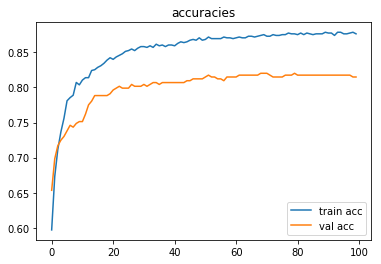

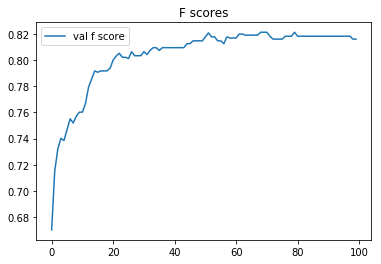

In [9]:

model = cuda(Model(num_features, hidden_layers = [], output_fcn = 'logistic'))
train(epochs = num_epochs, verbosity = verb)
visualize()

Best Loss: 0.768138587474823
Best Acc: 0.693121693122
Best F score: 0.700543717235


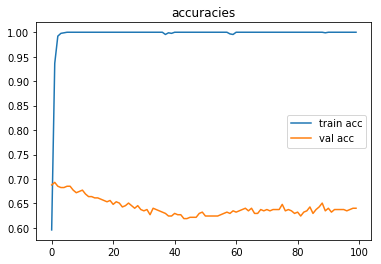

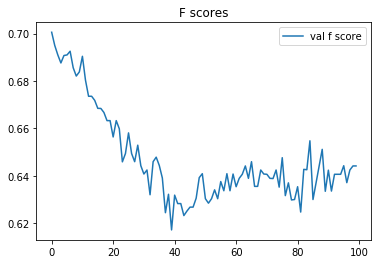

In [10]:

model = cuda(Model(num_features, hidden_layers = [], output_fcn = 'logistic', polynomial_features = True))
train(epochs = num_epochs, verbosity = verb)
visualize()

Best Loss: 0.39449790120124817
Best Acc: 0.84126984127
Best F score: 0.838644046413


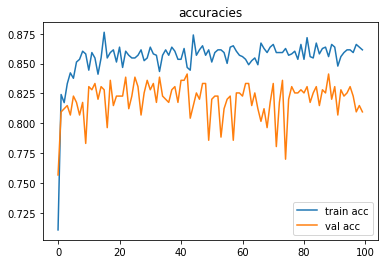

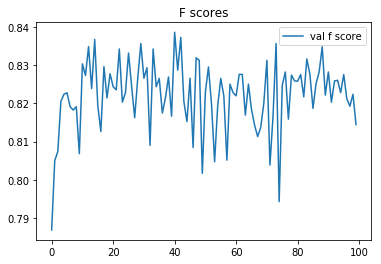

In [11]:

model = cuda(Model(num_features, hidden_layers = [1000], output_fcn = 'logistic'))
train(epochs = num_epochs, verbosity = verb)
visualize()

Best Loss: 0.3870002031326294
Best Acc: 0.854497354497
Best F score: 0.852329897383


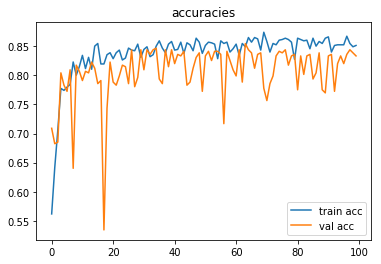

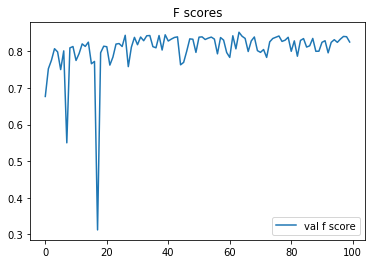

In [12]:

model = cuda(Model(num_features, hidden_layers = [1000, 1000], output_fcn = 'logistic'))
train(epochs = num_epochs, verbosity = verb)
visualize()